In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

### Loading Data

In [3]:
train_dir = "../data/processed/train"
val_dir = "../data/processed/val"
test_dir = "../data/processed/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

# Storing class names
class_names = train_ds.class_names
print("Classes:", class_names)

Found 14437 files belonging to 15 classes.
Found 3097 files belonging to 15 classes.
Found 3104 files belonging to 15 classes.
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


### Data Distribution

In [5]:
y_train = []
for images, labels in train_ds:
    y_train.extend(labels.numpy())
y_train = np.array(y_train)

# Count samples per class
unique, counts = np.unique(y_train, return_counts=True)
print("\nSamples per class:")
for i, (class_idx, count) in enumerate(zip(unique, counts)):
    print(f"{class_names[class_idx]}: {count}")


Samples per class:
Pepper__bell___Bacterial_spot: 697
Pepper__bell___healthy: 1034
Potato___Early_blight: 699
Potato___Late_blight: 699
Potato___healthy: 106
Tomato_Bacterial_spot: 1488
Tomato_Early_blight: 699
Tomato_Late_blight: 1336
Tomato_Leaf_Mold: 666
Tomato_Septoria_leaf_spot: 1239
Tomato_Spider_mites_Two_spotted_spider_mite: 1173
Tomato__Target_Spot: 982
Tomato__Tomato_YellowLeaf__Curl_Virus: 2245
Tomato__Tomato_mosaic_virus: 261
Tomato_healthy: 1113


### Calculating the weigths for the imbalances

In [6]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(zip(range(len(class_weights)), class_weights))
print("\nClass weights:")
for i, weight in enumerate(class_weights):
    print(f"{class_names[i]}: {weight:.3f}")


Class weights:
Pepper__bell___Bacterial_spot: 1.381
Pepper__bell___healthy: 0.931
Potato___Early_blight: 1.377
Potato___Late_blight: 1.377
Potato___healthy: 9.080
Tomato_Bacterial_spot: 0.647
Tomato_Early_blight: 1.377
Tomato_Late_blight: 0.720
Tomato_Leaf_Mold: 1.445
Tomato_Septoria_leaf_spot: 0.777
Tomato_Spider_mites_Two_spotted_spider_mite: 0.821
Tomato__Target_Spot: 0.980
Tomato__Tomato_YellowLeaf__Curl_Virus: 0.429
Tomato__Tomato_mosaic_virus: 3.688
Tomato_healthy: 0.865


### Preprocessing

In [7]:
def preprocess(ds):
    return ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)) \
             .cache().prefetch(tf.data.AUTOTUNE)

train_ds = preprocess(train_ds)
val_ds = preprocess(val_ds)
test_ds = preprocess(test_ds)

### Base Model

In [10]:
from tensorflow.keras import layers 

model = tf.keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    
    # Simple conv layers
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

### Compiling Model

In [11]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Training Model

In [12]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight_dict
)

Epoch 1/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 279s 613ms/step - accuracy: 0.1924 - loss: 2.5235 - val_accuracy: 0.5864 - val_loss: 1.4352
Epoch 2/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 300s 663ms/step - accuracy: 0.4961 - loss: 1.6043 - val_accuracy: 0.7123 - val_loss: 0.9594
Epoch 3/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 291s 643ms/step - accuracy: 0.5915 - loss: 1.2581 - val_accuracy: 0.6623 - val_loss: 1.0729
Epoch 4/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 288s 637ms/step - accuracy: 0.6336 - loss: 1.1188 - val_accuracy: 0.7846 - val_loss: 0.6715
Epoch 5/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 285s 630ms/step - accuracy: 0.6811 - loss: 0.9389 - val_accuracy: 0.8098 - val_loss: 0.6001
Epoch 6/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 294s 650ms/step - accuracy: 0.7103 - loss: 0.8510 - val_accuracy: 0.7979 - val_loss: 0.6355
Epoch 7/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 289s 639ms/step - accuracy: 0.7379 - loss: 0.7511 - val_accuracy: 0.7892 - val_loss: 0.6806
Epoch 8/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 295s 652ms/step - accuracy: 0.7586 -

### Evaluating the model

In [13]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.8191 - loss: 0.5495

Test Accuracy: 0.8235
Test Loss: 0.5517


### Detailed evaluation

In [14]:
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.75      0.71      0.73       150
                     Pepper__bell___healthy       0.86      0.86      0.86       222
                      Potato___Early_blight       0.83      0.91      0.87       151
                       Potato___Late_blight       0.76      0.87      0.81       151
                           Potato___healthy       0.64      0.78      0.71        23
                      Tomato_Bacterial_spot       0.87      0.94      0.90       320
                        Tomato_Early_blight       0.65      0.54      0.59       151
                         Tomato_Late_blight       0.85      0.68      0.76       287
                           Tomato_Leaf_Mold       0.83      0.73      0.78       143
                  Tomato_Septoria_leaf_spot       0.73      0.73      0.73       266
Tomato_Spider_mites_Two_spotted_spider_m

### Plot Results

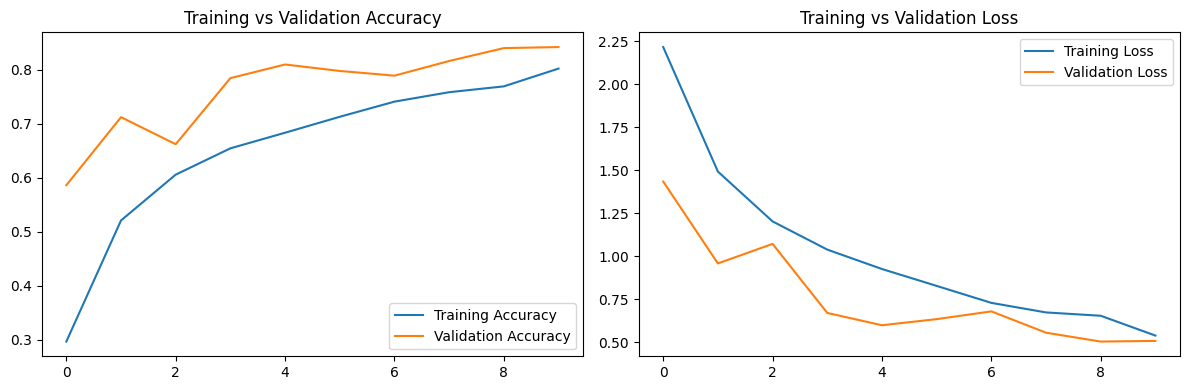

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.tight_layout()
plt.show()

### Saving Model

In [16]:
model.save('plant_disease_model.keras')
print("Model saved successfully")

Model saved successfully


### Enhanced training for better results

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

### Improved model compilation with better learning rate

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Enhanced training with callbacks

In [24]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Training with enhanced callbacks...")
history = model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=10,  
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Training with enhanced callbacks...
Epoch 1/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.9438 - loss: 0.1415
Epoch 1: val_accuracy improved from -inf to 0.88699, saving model to best_model.keras
452/452 ━━━━━━━━━━━━━━━━━━━━ 405s 896ms/step - accuracy: 0.9438 - loss: 0.1415 - val_accuracy: 0.8870 - val_loss: 0.4608 - learning_rate: 1.2500e-04
Epoch 2/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.9445 - loss: 0.1469
Epoch 2: val_accuracy improved from 0.88699 to 0.89506, saving model to best_model.keras
452/452 ━━━━━━━━━━━━━━━━━━━━ 276s 610ms/step - accuracy: 0.9445 - loss: 0.1469 - val_accuracy: 0.8951 - val_loss: 0.4353 - learning_rate: 1.2500e-04
Epoch 3/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.9487 - loss: 0.1382
Epoch 3: val_accuracy did not improve from 0.89506
452/452 ━━━━━━━━━━━━━━━━━━━━ 295s 652ms/step - accuracy: 0.9487 - loss: 0.1382 - val_accuracy: 0.8944 - val_loss: 0.4408 - learning_rate: 1.2500e-04
Epoch 4/10
452/452 ━━━━━━━━

### Saving latest model

In [25]:
model.save('folia_2.keras')
print("Model saved successfully")

Model saved successfully


### Evaluating latest model  on test data

In [26]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"\nfolia_2 Test Accuracy: {test_accuracy:.4f}")
print(f"folia_2 Test Loss: {test_loss:.4f}")

97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step - accuracy: 0.8850 - loss: 0.4890

folia_2 Test Accuracy: 0.8831
folia_2 Test Loss: 0.4909


### Detailed Evaluation on latest model

In [27]:
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

print("\nfolia_2 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


folia_2 Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.83      0.82      0.83       150
                     Pepper__bell___healthy       0.90      0.95      0.92       222
                      Potato___Early_blight       0.91      0.91      0.91       151
                       Potato___Late_blight       0.87      0.82      0.85       151
                           Potato___healthy       0.82      0.78      0.80        23
                      Tomato_Bacterial_spot       0.94      0.97      0.95       320
                        Tomato_Early_blight       0.74      0.66      0.70       151
                         Tomato_Late_blight       0.81      0.87      0.84       287
                           Tomato_Leaf_Mold       0.90      0.79      0.84       143
                  Tomato_Septoria_leaf_spot       0.78      0.81      0.79       266
Tomato_Spider_mites_Two_spotted_

### Training Curves

Text(0, 0.5, 'Loss')

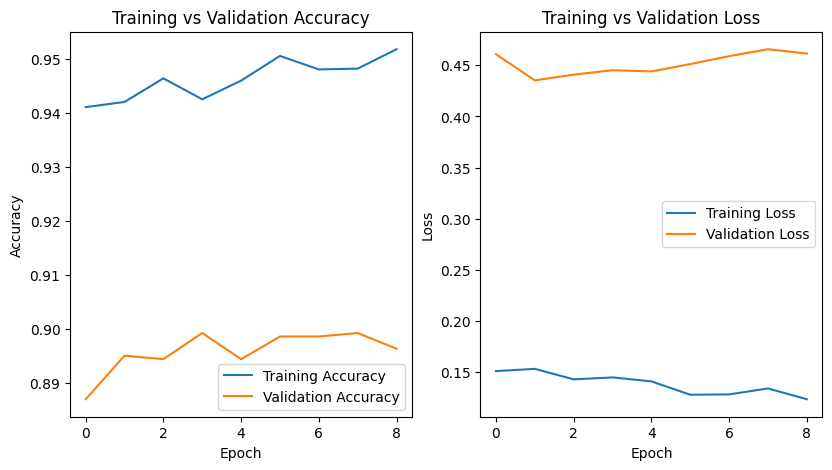

In [28]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')